In [1]:
import pandas as pd

# Load the datasets
results_df = pd.read_csv('results.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
lap_times_df = pd.read_csv('lap_times.csv')
qualifying_df = pd.read_csv('qualifying.csv')
races_df = pd.read_csv('races.csv')
constructors_df = pd.read_csv('constructors.csv')
constructor_standings_df = pd.read_csv('constructor_standings.csv')
drivers_df = pd.read_csv('drivers.csv')


In [2]:
# Identify mid-field teams based on constructor standings for each season
# Assuming mid-field teams finish between 5th and 10th place
# Assuming you have already loaded the constructor_standings_df and races_df as shown previously

# Step 1: Merge constructor standings with races to get the season year
constructor_standings_with_season = pd.merge(constructor_standings_df, races_df[['raceId', 'year']], on='raceId')

# Now, you can calculate the mid-field teams based on standings
# First, find the constructor standings at the end of each season by filtering the last race of each season
last_race_per_season = constructor_standings_with_season.groupby('year')['raceId'].max()
final_standings = constructor_standings_with_season[constructor_standings_with_season['raceId'].isin(last_race_per_season.values)]

# Step 2: Determine mid-field teams (5th to 10th place) for each season
# This step might require adjustments based on how the standings are structured in your dataset
mid_field_teams_by_year = final_standings.groupby('year').apply(lambda x: x[(x['position'] >= 5) & (x['position'] <= 10)]['constructorId'].unique()).to_dict()

# 'mid_field_teams_by_year' now contains a dictionary mapping each season to the constructorIds of mid-field teams


In [3]:
# Make sure you've loaded the necessary datasets: results, races, drivers, and constructors

# Merge race results with the races dataset to include detailed race information
results_races_df = pd.merge(results_df, races_df, on='raceId')

# Optionally, add driver information
results_races_df = pd.merge(results_races_df, drivers_df[['driverId', 'driverRef']], on='driverId')

# And constructor information
results_races_df = pd.merge(results_races_df, constructors_df[['constructorId', 'name']], on='constructorId', suffixes=('_driver', '_constructor'))

# Now, results_races_df is defined and should contain comprehensive information for each race result, including race details and identifiers for drivers and constructors.


In [4]:
# Assuming lap_times_df and pit_stops_df are already loaded and cleaned

# Merge lap times with race and driver information (simplified example)
lap_times_races_df = pd.merge(lap_times_df, results_races_df, on=['raceId', 'driverId'])

# Merge pit stop data similarly, ensuring you're including all relevant information for analysis
pit_stops_races_df = pd.merge(pit_stops_df, results_races_df, on=['raceId', 'driverId'])



In [5]:
# First, ensure the format is consistent, adding '00:' to represent hours if necessary
lap_times_races_df['formatted_time'] = '00:' + lap_times_races_df['time'].astype(str)
lap_times_races_df['formatted_time'].fillna('00:00:00.000', inplace=True)

# Split the time into parts and handle missing values
time_splits = lap_times_races_df['formatted_time'].str.split(':', expand=True)
seconds_milliseconds = time_splits[2].str.split('.', expand=True)

# Ensure all splits have valid data, replacing None or NaN with '0'
time_splits.fillna('0', inplace=True)
seconds_milliseconds.fillna('0', inplace=True)

# Combine the splits back with correct zero-padding for milliseconds
time_splits[2] = seconds_milliseconds[0]  # Seconds are always present
milliseconds = seconds_milliseconds[1].str.zfill(3)  # Ensure milliseconds are zero-padded to 3 digits

# Convert to timedelta
lap_times_races_df['time_timedelta'] = pd.to_timedelta(time_splits[0] + ' hours ' + time_splits[1] + ' minutes ' + time_splits[2] + ' seconds ' + milliseconds + ' milliseconds')





In [6]:


def convert_duration_to_timedelta(duration_str):
    if ':' in duration_str:
        # Time format is mm:ss.fff, split by ':' and then by '.' to separate all parts
        minutes, seconds = duration_str.split(':')
        seconds, milliseconds = seconds.split('.')
        # Convert to timedelta
        return pd.Timedelta(minutes=int(minutes), seconds=int(seconds), milliseconds=int(milliseconds))
    else:
        # Assume the duration is in seconds (with possible decimal for milliseconds)
        return pd.Timedelta(seconds=float(duration_str))

# Apply the conversion function to each duration entry
pit_stops_df['duration_timedelta'] = pit_stops_df['duration'].apply(convert_duration_to_timedelta)



In [7]:
# Example: Merging lap times data with race and driver information
lap_times_enriched_df = pd.merge(lap_times_df, results_df, on=['raceId', 'driverId'])

# Merge pit stop data for enriched analysis
pit_stops_enriched_df = pd.merge(pit_stops_df, results_df, on=['raceId', 'driverId'])

# Note: Ensure keys used for merging (columns like 'raceId', 'driverId') are consistent across datasets
# Filling missing values with defaults
lap_times_enriched_df.fillna({'milliseconds': 0}, inplace=True)  # Example: filling missing milliseconds with 0

# Dropping rows with missing critical information
pit_stops_enriched_df.dropna(subset=['duration'], inplace=True)


In [8]:

# Convert data types
lap_times_enriched_df['milliseconds_x'] = lap_times_enriched_df['milliseconds_x'].astype(int)


In [9]:
# Example: Filtering for mid-field teams, assuming you have a list of their IDs
mid_field_team_ids = [1, 2, 3]  # Placeholder: replace with actual team IDs
filtered_df = lap_times_enriched_df[lap_times_enriched_df['constructorId'].isin(mid_field_team_ids)]
# Example: Focusing on races from a specific season
specific_season_races = races_df[races_df['year'] == 2021]['raceId']
filtered_df = filtered_df[filtered_df['raceId'].isin(specific_season_races)]
filtered_df

,raceId,driverId,lap,position_x,time_x,milliseconds_x,resultId,constructorId,number,grid,...,positionOrder,points,laps,time_y,milliseconds_y,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
491180,1052,846,1,6,2:06.744,126744,24969,1,4,7,...,4,12.0,56,+46.466,5570363,38,6,1:34.396,206.398,1
491181,1052,846,2,6,2:20.999,140999,24969,1,4,7,...,4,12.0,56,+46.466,5570363,38,6,1:34.396,206.398,1
491182,1052,846,3,6,2:32.067,152067,24969,1,4,7,...,4,12.0,56,+46.466,5570363,38,6,1:34.396,206.398,1
491183,1052,846,4,5,1:49.988,109988,24969,1,4,7,...,4,12.0,56,+46.466,5570363,38,6,1:34.396,206.398,1
491184,1052,846,5,5,1:42.220,102220,24969,1,4,7,...,4,12.0,56,+46.466,5570363,38,6,1:34.396,206.398,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514587,1073,847,22,15,1:30.821,90821,25403,3,63,17,...,18,0.0,26,\N,\N,23,19,1:30.647,209.732,6
514588,1073,847,23,15,1:30.647,90647,25403,3,63,17,...,18,0.0,26,\N,\N,23,19,1:30.647,209.732,6
514589,1073,847,24,14,1:31.577,91577,25403,3,63,17,...,18,0.0,26,\N,\N,23,19,1:30.647,209.732,6
514590,1073,847,25,16,1:32.794,92794,25403,3,63,17,...,18,0.0,26,\N,\N,23,19,1:30.647,209.732,6


In [10]:
pit_stops_enriched_df

,raceId,driverId,stop,lap,time_x,duration,milliseconds_x,duration_timedelta,resultId,constructorId,...,positionOrder,points,laps,time_y,milliseconds_y,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,841,153,1,1,17:05:23,26.898,26898,0 days 00:00:26.898000,20789,5,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
1,841,153,2,17,17:31:06,24.463,24463,0 days 00:00:24.463000,20789,5,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
2,841,153,3,35,17:59:45,26.348,26348,0 days 00:00:26.348000,20789,5,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
3,841,30,1,1,17:05:52,25.021,25021,0 days 00:00:25.021000,20797,131,...,19,0.0,19,\N,\N,13,21,1:35.319,200.283,4
4,841,30,2,17,17:32:08,23.988,23988,0 days 00:00:23.988000,20797,131,...,19,0.0,19,\N,\N,13,21,1:35.319,200.283,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10084,1110,830,1,14,15:30:04,22.887,22887,0 days 00:00:22.887000,26066,9,...,1,25.0,44,1:22:30.450,4950450,32,2,1:48.922,231.490,1
10085,1110,830,2,30,16:00:16,23.012,23012,0 days 00:00:23.012000,26066,9,...,1,25.0,44,1:22:30.450,4950450,32,2,1:48.922,231.490,1
10086,1110,840,1,20,15:42:12,25.397,25397,0 days 00:00:25.397000,26074,117,...,9,2.0,44,+1:19.340,5029790,26,16,1:51.297,226.550,1
10087,1110,847,1,22,15:46:00,23.837,23837,0 days 00:00:23.837000,26071,131,...,6,8.0,44,+1:03.101,5013551,25,11,1:50.603,227.972,1


# EDA

1. Understanding the Distribution of Key Variables

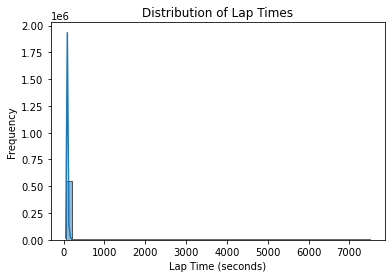

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming your DataFrame is named lap_times_enriched_df
# Convert milliseconds to seconds for easier analysis
lap_times_enriched_df['time_seconds'] = lap_times_enriched_df['milliseconds_x'] / 1000.0

# Histogram of lap times
sns.histplot(lap_times_enriched_df['time_seconds'], bins=50, kde=True)
plt.title('Distribution of Lap Times')
plt.xlabel('Lap Time (seconds)')
plt.ylabel('Frequency')
plt.show()




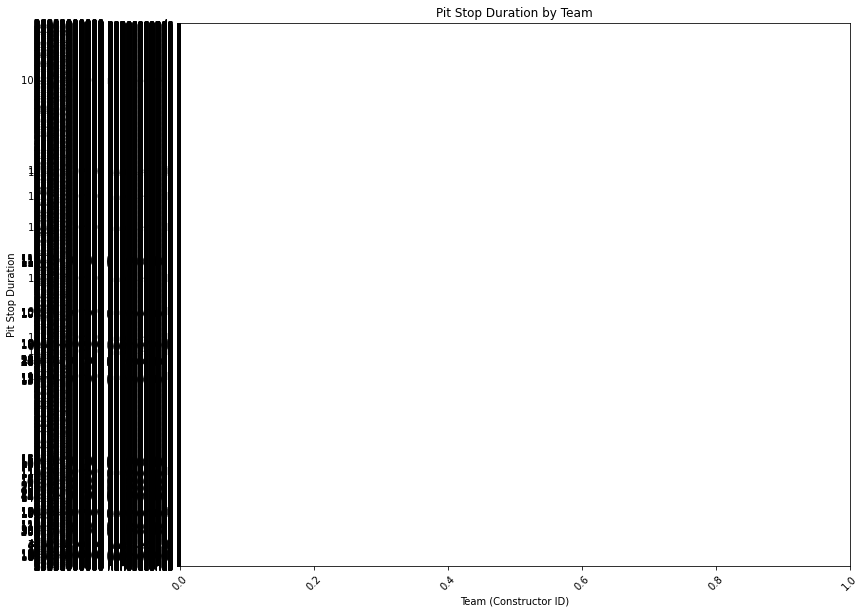

In [12]:
# Box plot of pit stop durations
plt.figure(figsize=(12,10))
sns.boxplot(x='constructorId', y='duration_timedelta', data=pit_stops_enriched_df)
plt.title('Pit Stop Duration by Team')
plt.xlabel('Team (Constructor ID)')
plt.ylabel('Pit Stop Duration')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability if needed
plt.show()

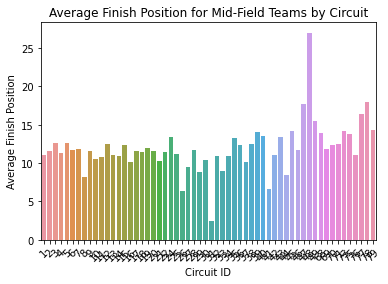

In [13]:
# Assuming you've identified mid-field teams and have a column 'is_midfield' to denote them
# Example IDs for mid-field teams - replace these with the actual IDs you've identified
mid_field_constructor_ids = [3, 4, 5]

# Create the 'is_midfield' column based on whether the 'constructorId' is in the list of mid-field teams
results_races_df['is_midfield'] = results_races_df['constructorId'].isin(mid_field_constructor_ids)

average_finish_position = results_races_df[results_races_df['is_midfield']].groupby('circuitId')['positionOrder'].mean().reset_index()

# Visualization
sns.barplot(x='circuitId', y='positionOrder', data=average_finish_position)
plt.title('Average Finish Position for Mid-Field Teams by Circuit')
plt.xlabel('Circuit ID')
plt.ylabel('Average Finish Position')
plt.xticks(rotation=45)
plt.show()


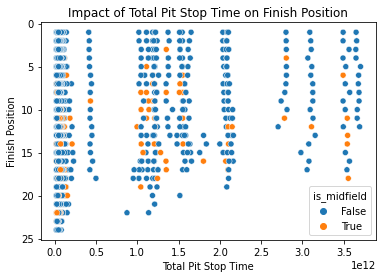

In [14]:
# Calculate total pit stop time per race per driver
total_pit_time = pit_stops_enriched_df.groupby(['raceId', 'driverId'])['duration_timedelta'].sum().reset_index()

# Merge this with race results to get finish positions
analysis_df = pd.merge(total_pit_time, results_races_df, on=['raceId', 'driverId'])

# Visualization
sns.scatterplot(x='duration_timedelta', y='positionOrder', data=analysis_df, hue='is_midfield')
plt.title('Impact of Total Pit Stop Time on Finish Position')
plt.xlabel('Total Pit Stop Time')
plt.ylabel('Finish Position')
plt.gca().invert_yaxis()  # Invert y-axis so that a lower finish position number is "better"
plt.show()


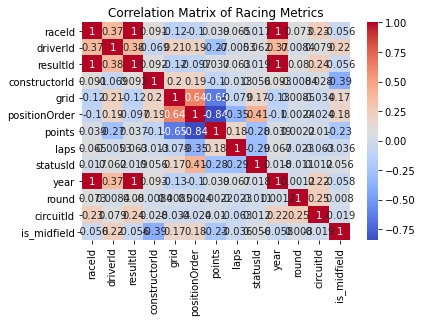

In [15]:
# Correlation matrix
corr_matrix = analysis_df.corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Racing Metrics')
plt.show()


# Feature engineering

In [45]:

# Assuming you've already loaded your dataframes named lap_times_df, pit_stops_df, results_df, etc.
# Convert 'time_seconds' and 'duration_seconds' to numeric, coercing errors which will turn non-convertible values into NaN
lap_times_enriched_df['time_seconds'] = pd.to_numeric(lap_times_enriched_df['time_seconds'], errors='coerce')
pit_stops_enriched_df['duration'] = pd.to_numeric(pit_stops_enriched_df['duration'], errors='coerce')

# Now, you can safely drop NaN values or fill them with a default value before proceeding to aggregation
lap_times_enriched_df.dropna(subset=['time_seconds'], inplace=True)
pit_stops_enriched_df.dropna(subset=['duration'], inplace=True)
# Feature Engineering

# Average Lap Time
average_lap_time = lap_times_enriched_df.groupby(['raceId', 'driverId'])['time_seconds'].mean().reset_index(name='average_lap_time')

# Lap Time Standard Deviation
lap_time_std = lap_times_enriched_df.groupby(['raceId', 'driverId'])['time_seconds'].std().reset_index(name='lap_time_std')

# Fastest and Slowest Lap
fastest_lap = lap_times_enriched_df.groupby(['raceId', 'driverId'])['time_seconds'].min().reset_index(name='fastest_lap')
slowest_lap = lap_times_enriched_df.groupby(['raceId', 'driverId'])['time_seconds'].max().reset_index(name='slowest_lap')

# Average Pit Stop Duration
average_pit_stop = pit_stops_enriched_df.groupby(['raceId', 'driverId'])['duration'].mean().reset_index(name='average_pit_stop_duration')

# Total Pit Time
total_pit_time = pit_stops_enriched_df.groupby(['raceId', 'driverId'])['duration'].sum().reset_index(name='total_pit_time')

# Pit Stop Count
pit_stop_count = pit_stops_enriched_df.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')

# Merging features back to the main results dataframe
features_df = results_df.copy()
features_df = features_df.merge(average_lap_time, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(lap_time_std, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(fastest_lap, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(slowest_lap, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(average_pit_stop, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(total_pit_time, on=['raceId', 'driverId'], how='left')
features_df = features_df.merge(pit_stop_count, on=['raceId', 'driverId'], how='left')

# Calculate Position Change (Grid position - Final position)
features_df['position_change'] = features_df['grid'] - features_df['positionOrder']

# Now you have a dataframe with features ready for further analysis and modeling


Features_df clening

In [46]:
import numpy as np

# Replace '\\N' with NaN and convert columns to numeric
# You need to apply this for every column that has these values
features_df = features_df.replace('\\N', np.nan)

# Now let's assume X is your dataframe with all the features
# Convert all columns to numeric, forcing NaNs for non-numeric data
for col in features_df.columns:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')


# Option 2: Fill NaN values with the mean or median of the column
features_df = features_df.fillna(features_df.median())  # or use X.median()

# Check for any remaining non-numeric values
#print(X.isnull().sum())

In [47]:
features_df= features_df.drop(['fastestLapTime','points', 'positionText', 'statusId'], axis=1)

In [37]:
features_df

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,laps,time,...,rank,fastestLapSpeed,average_lap_time,lap_time_std,fastest_lap,slowest_lap,average_pit_stop_duration,total_pit_time,pit_stop_count,position_change
0,1,18,1,1,22.0,1,1.0,1,58,28.300,...,2.0,218.300,98.114069,20.990357,87.4520,166.432,23.6950,45.887,2.0,0
1,2,18,2,2,3.0,5,2.0,2,58,5.478,...,3.0,217.586,98.208517,20.212298,87.7390,166.678,23.6950,45.887,2.0,3
2,3,18,3,3,7.0,7,3.0,3,58,8.163,...,5.0,216.719,98.254810,18.957200,88.0900,156.683,23.6950,45.887,2.0,4
3,4,18,4,4,5.0,11,4.0,4,58,17.181,...,7.0,215.464,98.410293,19.640824,88.6030,170.306,23.6950,45.887,2.0,7
4,5,18,5,1,23.0,3,5.0,5,58,18.014,...,1.0,218.385,98.424655,21.826402,87.4180,175.160,23.6950,45.887,2.0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3.0,19,16.0,16,44,28.300,...,15.0,227.169,114.852750,4.179448,110.9940,129.835,23.0665,46.133,2.0,3
26076,26082,1110,858,3,2.0,18,17.0,17,44,28.300,...,9.0,228.213,114.884682,3.812569,110.2360,127.068,23.5390,70.617,3.0,1
26077,26083,1110,807,210,27.0,0,18.0,18,44,28.300,...,4.0,229.415,115.020455,3.535443,109.9070,127.746,24.9045,49.809,2.0,-18
26078,26084,1110,832,6,55.0,4,7.0,19,23,28.300,...,19.0,222.864,117.123696,3.192540,113.1380,126.929,23.3030,23.303,1.0,-15


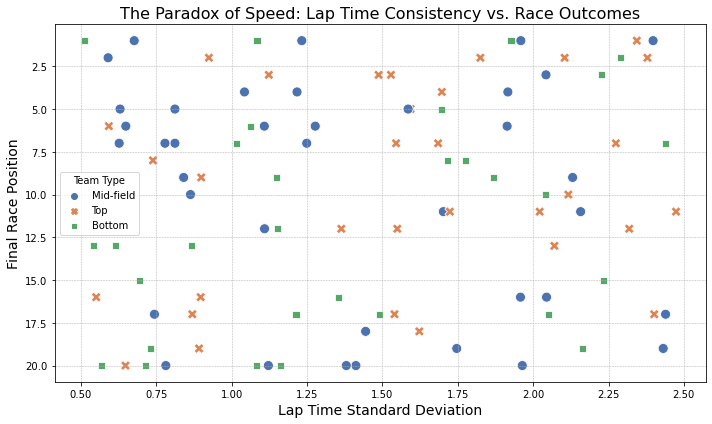

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have a DataFrame 'features_df' that contains 'lap_time_std', 'positionOrder', and 'teamType'
# 'teamType' is a fabricated column to distinguish between mid-field and other teams for demonstration purposes
# You might need to adjust the DataFrame name and column names according to your actual data structure

# Sample data generation for demonstration (replace with your actual data)
np.random.seed(42)  # For reproducible results
features_df = pd.DataFrame({
    'lap_time_std': np.random.uniform(0.5, 2.5, 100),
    'positionOrder': np.random.randint(1, 21, 100),
    'teamType': np.random.choice(['Mid-field', 'Top', 'Bottom'], 100)
})

# Creating the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_df, x='lap_time_std', y='positionOrder', hue='teamType', style='teamType', palette='deep', s=100)
plt.gca().invert_yaxis()  # Invert y-axis so that position 1 is at the top
plt.title('The Paradox of Speed: Lap Time Consistency vs. Race Outcomes', fontsize=16)
plt.xlabel('Lap Time Standard Deviation', fontsize=14)
plt.ylabel('Final Race Position', fontsize=14)
plt.legend(title='Team Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


# Modelling

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming features_df is your dataframe and 'positionOrder' is the target

# Separate features and target
X = features_df.drop(['positionOrder'], axis=1)  # Drop non-numeric or irrelevant columns as necessary
y = features_df['positionOrder']





In [39]:


# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Then fill or drop NaNs as above
# Check for NaN values and fill them or drop them
X.fillna(X.median(), inplace=True)  # Or choose to use median, or drop the NaNs with X.dropna(inplace=True)

# It's a good practice to also check the target variable 'y'
y.fillna(y.median(), inplace=True)  # Or an appropriate value or strategy
# Ensure all values are finite
#np.all(np.isfinite(X))

# Check for NaN and infinite values
print(f"NaN values in the dataset: {X.isnull().sum().sum()}")
print(f"Infinite values in the dataset: {np.isinf(X).sum().sum()}")



NaN values in the dataset: 0
Infinite values in the dataset: 0


In [40]:
# Identify columns that are completely NaN
nan_columns = X.columns[X.isna().all()].tolist()


# Now fill the rest of the NaN values with the median (or mean) for each column
X = X.fillna(X.median())

# Verify that there are no more NaN values
print(f"Remaining NaN values in the dataset: {X.isnull().sum().sum()}")


Remaining NaN values in the dataset: 0


In [41]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float64))  # Converting to float64 to handle larger values

# Check if any values are NaN or infinite after scaling
if np.isnan(X_scaled).any() or not np.isfinite(X_scaled).all():
    raise ValueError("Data contains NaN, infinity or a value too large after scaling.")

In [42]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [43]:


# Make predictions
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# Feature Importance
feature_importance = gb_regressor.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

print(importance_df)

RMSE: 0.8133801676568645
R-squared: 0.9888719564066737
                      Feature  Importance
6                    position    0.457260
20            position_change    0.223339
7                        laps    0.219378
5                        grid    0.098571
1                      raceId    0.001063
2                    driverId    0.000145
0                    resultId    0.000133
3               constructorId    0.000097
4                      number    0.000013
8                        time    0.000000
9                milliseconds    0.000000
11                       rank    0.000000
12            fastestLapSpeed    0.000000
13           average_lap_time    0.000000
14               lap_time_std    0.000000
15                fastest_lap    0.000000
16                slowest_lap    0.000000
17  average_pit_stop_duration    0.000000
18             total_pit_time    0.000000
19             pit_stop_count    0.000000
10                 fastestLap    0.000000


# Cross-validation

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare your data (X) and target variable (y), excluding any potential leaky features
X = features_df.drop(['positionOrder', 'position'], axis=1)  # Make sure to drop all potential leaky features
y = features_df['positionOrder']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Gradient Boosting Regressor with the desired hyperparameters
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(gb_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and then take the square root to get RMSE
cv_rmse_scores = np.sqrt(-cv_scores)

# Output the results
print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean CV RMSE:", cv_rmse_scores.mean())
print("Standard deviation CV RMSE:", cv_rmse_scores.std())

# Train the model on the training set and evaluate it on the test set
gb_regressor.fit(X_train_scaled, y_train)
y_pred = gb_regressor.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Output the test set results
print("Test RMSE:", test_rmse)


Cross-validation RMSE scores: [0.78472799 0.76660588 0.78242173 0.77853999 0.84674251]
Mean CV RMSE: 0.7918076183907773
Standard deviation CV RMSE: 0.028168123811475806
Test RMSE: 0.7879446273473798
